In [28]:
from matplotlib import pyplot as plt
import platform, os, sys, time, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, fmin_cg, approx_fprime
from numpy.linalg import norm
from numpy import Inf
from tqdm import tqdm
from termcolor import colored, cprint

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import interp2d, SmoothBivariateSpline, RectBivariateSpline

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Level 2: calculating electron positions using `scipy.minimize` on a FEM obtained potential

In [15]:
save = False
data_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Potentials/V6 - Greater Trap Area"

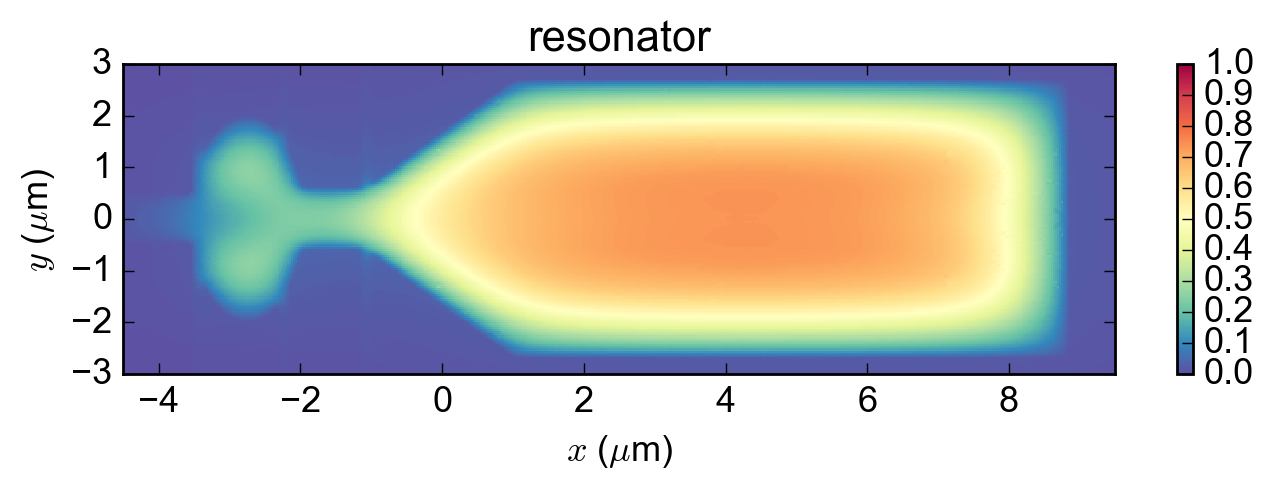

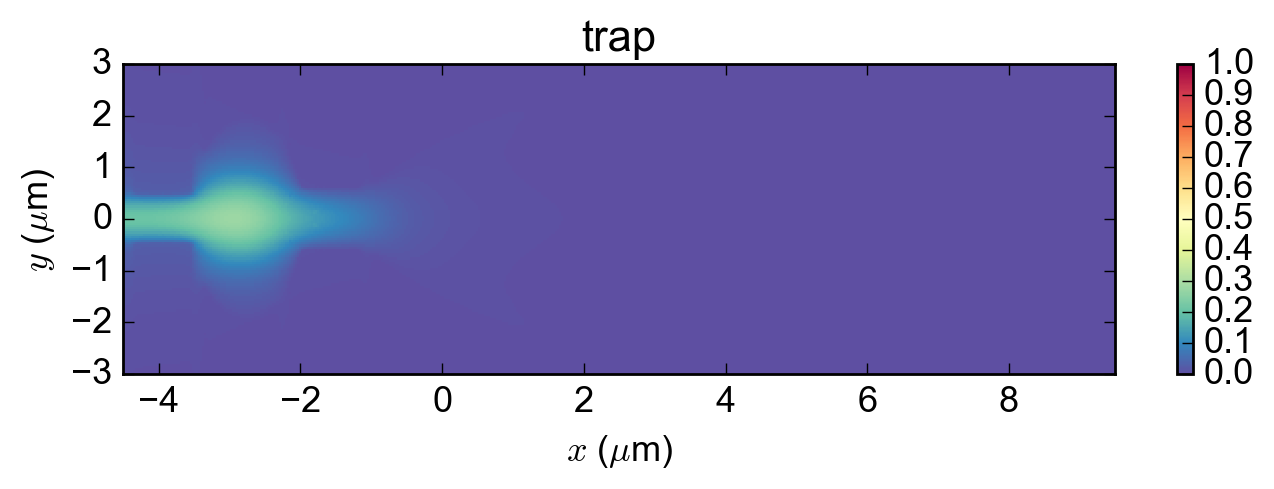

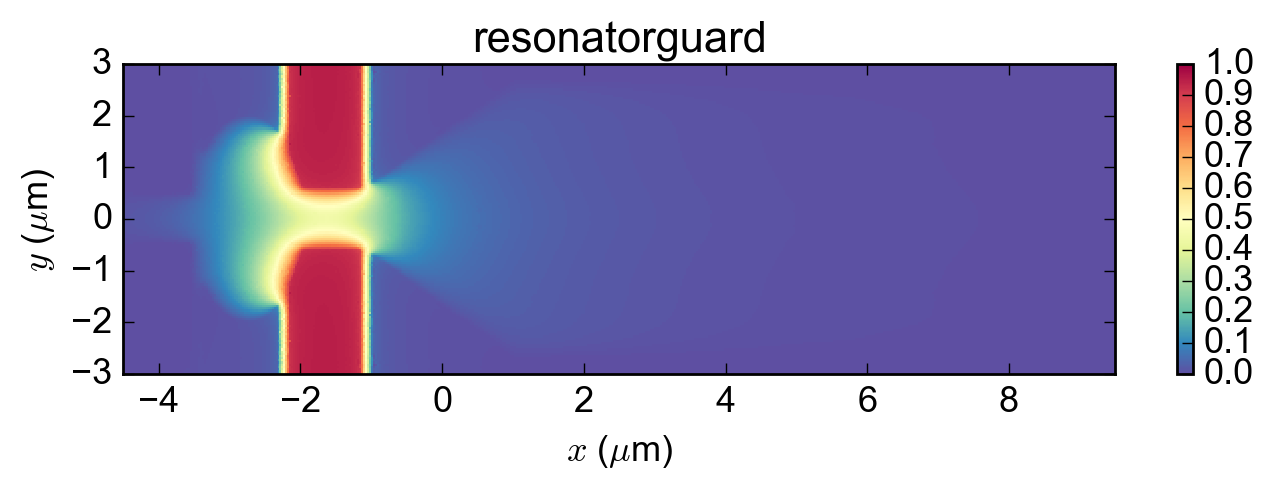

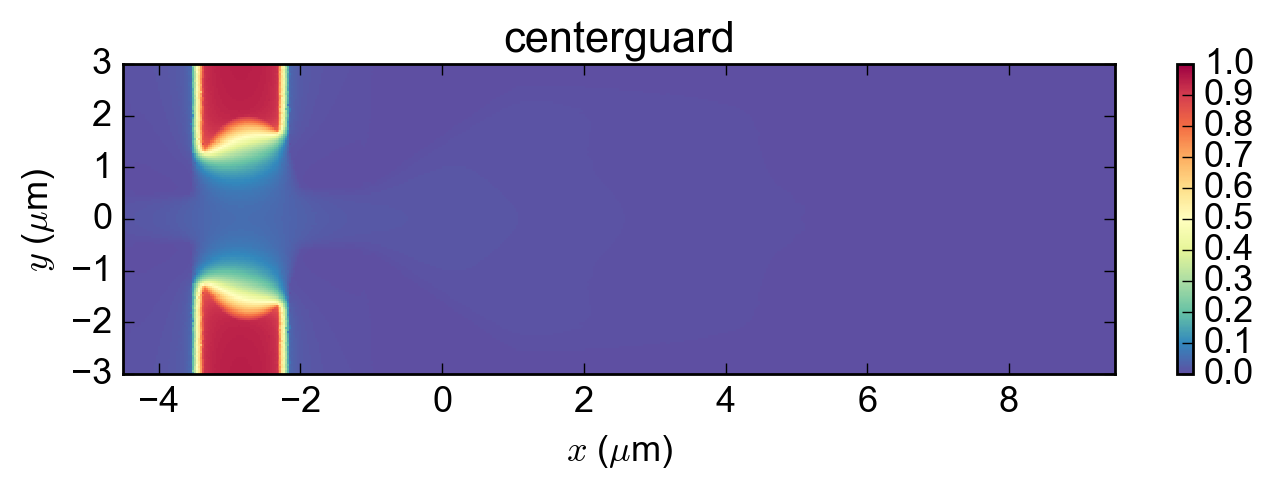

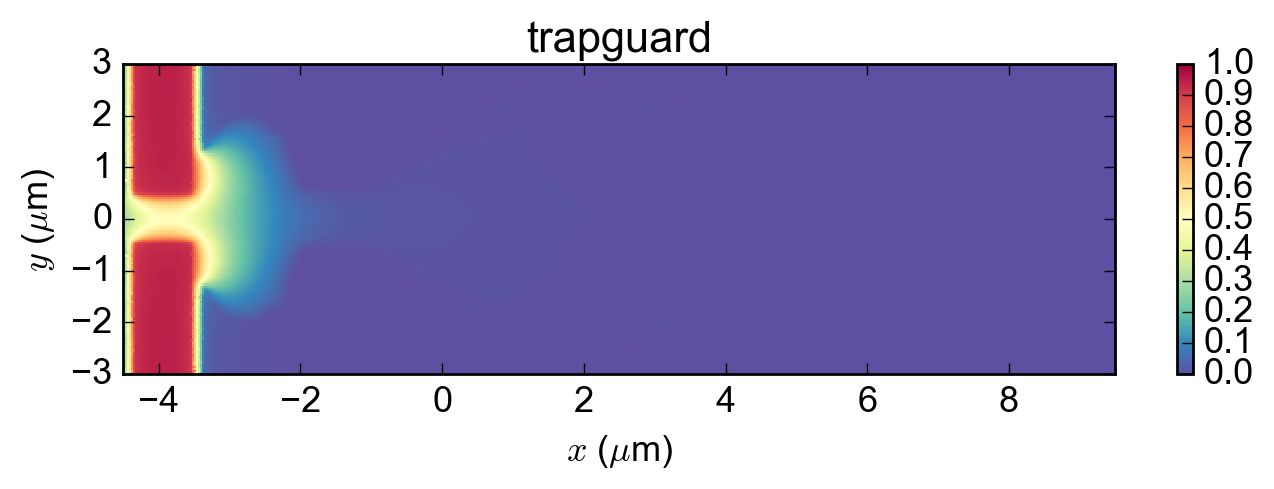

In [16]:
# Evaluate all files in the range. 
xeval=np.linspace(-4.5, 9.5, 501)

# Do not evaluate the files on the simulation boundary, this gives errors.
# Here I construct an array from y0 to -dy/2, with spacing dy. This limits
# our choice for y-points because, the spacing must be such that there's 
# an integer number of points in yeval. This can only be the case if 
# dy = 2 * ymin / (2*k+1) and Ny = ymin / dy - 0.5 + 1
# yeval = y0, y0 - dy, ... , -3dy/2, -dy/2

y0 = -3.0 # Starting point for y
k = 71 # This defines the sampling
dy = 2*np.abs(y0)/np.float(2*k+1) 
yeval = np.linspace(y0, -dy/2., (np.abs(y0)-0.5*dy)/dy + 1)

datafiles = [os.path.join(data_path, "Resonator.dsp"),
             os.path.join(data_path, "Trap.dsp"),
             os.path.join(data_path, "ResonatorGuard.dsp"),
             os.path.join(data_path, "CenterGuard.dsp"), 
             os.path.join(data_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    yedge = bounding_box[3]
    xdata -= xcenter
    ydata -= yedge
    #interpolate_slow.plot_mesh(os.path.join(datafile))
    xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, yeval=yeval, 
                                                                  clim=(0, 1.0), plot_axes='xy', 
                                                                  cmap=plt.cm.Spectral_r, plot_mesh=False, 
                                                                  plot_data=False)
    
    # Mirror around the y-axis
    ysize, xsize = np.shape(Uinterp)
    Uinterp_symmetric = np.zeros((2*ysize, xsize))
    Uinterp_symmetric[:ysize, :] = Uinterp
    Uinterp_symmetric[ysize:,:] = Uinterp[::-1,:]
    
    y_symmetric = np.zeros((2*ysize, xsize))
    y_symmetric[:ysize,:] = yinterp
    y_symmetric[ysize:,:] = -yinterp[::-1,:]
    
    x_symmetric = np.zeros((2*ysize, xsize))
    x_symmetric[:ysize,:] = xinterp
    x_symmetric[ysize:,:] = xinterp
    
    plt.figure(figsize=(8.,2.))
    common.configure_axes(13)
    plt.title(name)
    plt.pcolormesh(x_symmetric, y_symmetric, Uinterp_symmetric, cmap=plt.cm.Spectral_r, vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xlim(np.min(x_symmetric), np.max(x_symmetric))
    plt.ylim(np.min(y_symmetric), np.max(y_symmetric))
    plt.xlabel("$x$ ($\mu$m)")
    plt.ylabel("$y$ ($\mu$m)")
    
    output.append({'name' : name, 'V' : np.array(Uinterp_symmetric.T, dtype=np.float64),
                   'x' : np.array(x_symmetric.T, dtype=np.float64), 
                   'y' : np.array(y_symmetric.T, dtype=np.float64)})
    
    #plt.vlines(-1.5, np.min(yeval), np.max(yeval), linestyles="--", color="white")
    
yeval = np.append(yeval, -yeval[::-1])

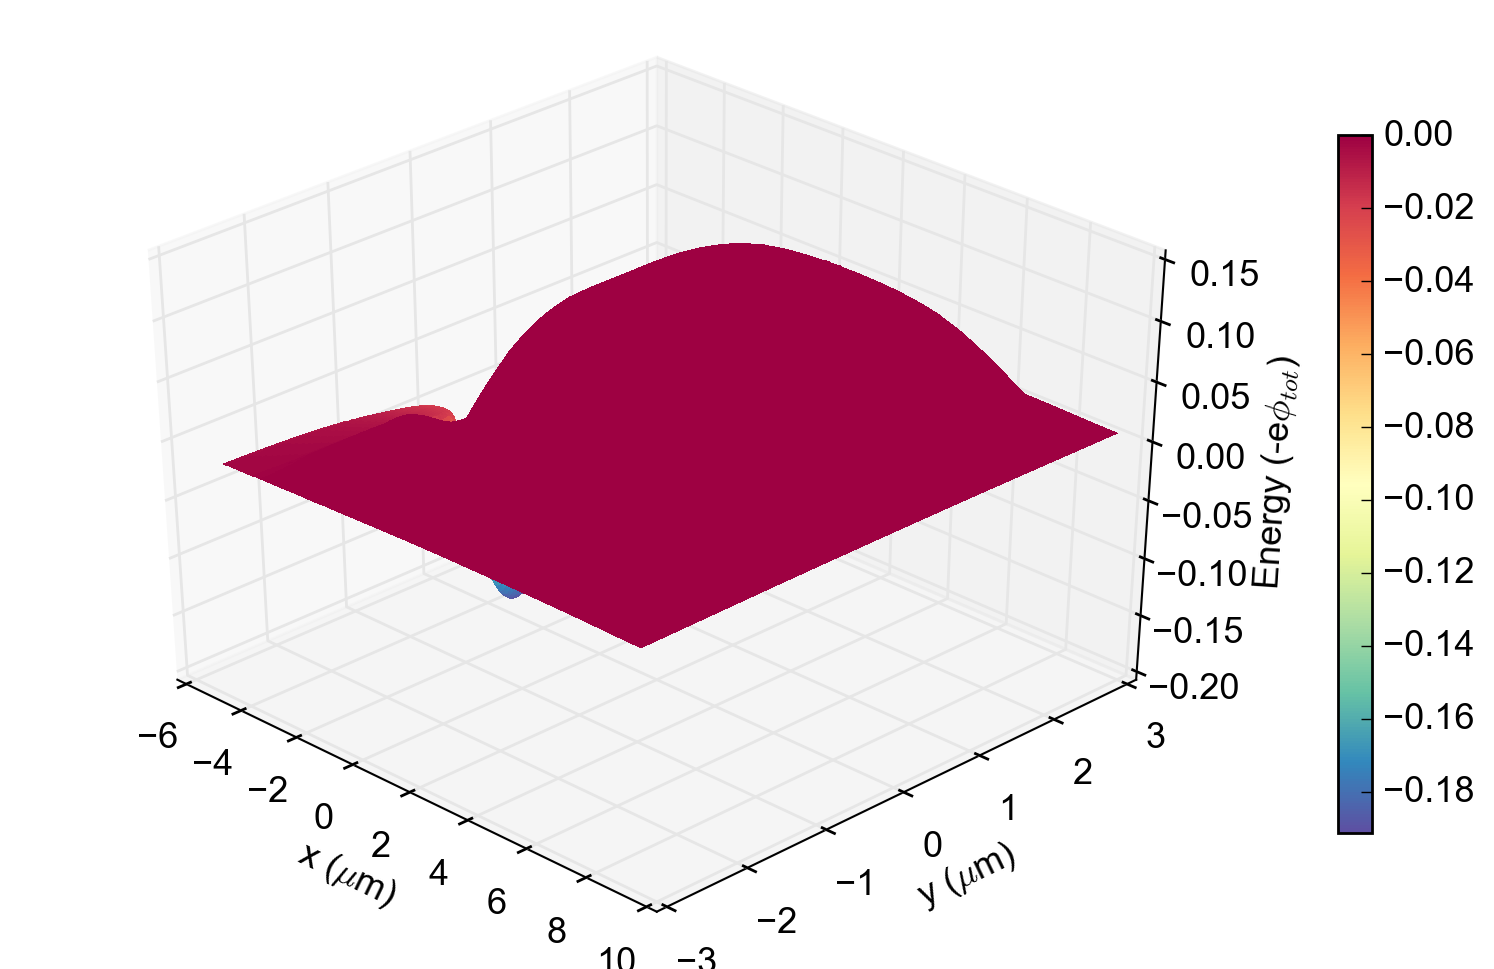

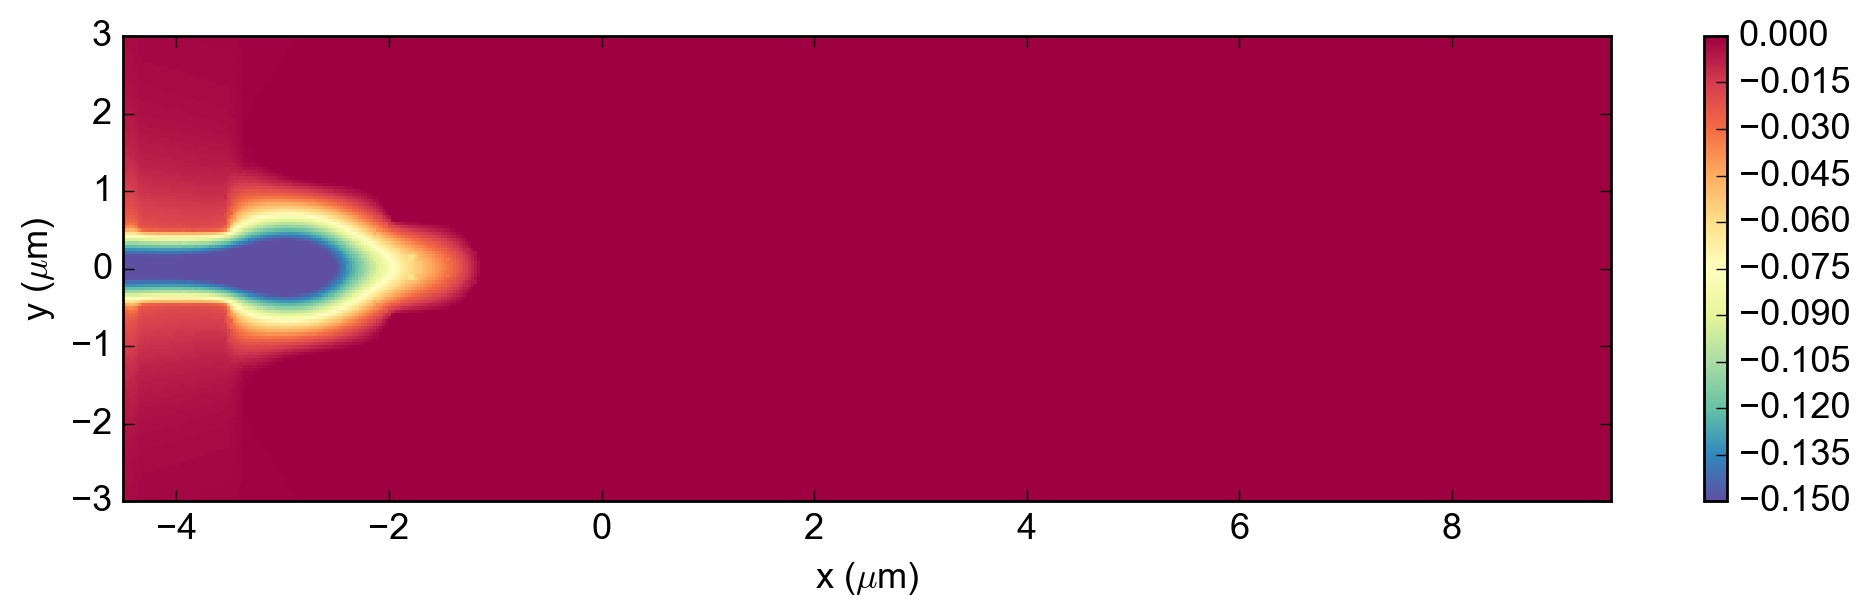

In [30]:
t = trap_analysis.TrapSolver()
c = trap_analysis.get_constants()

Vres = -0.20
Vtrap = 0.80
Vrg = -0.00
Vcg = -0.00
Vtg = -0.00

xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

Xm, Ym = np.meshgrid(xeval, yeval)

for view_angle in [-45]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -combined_potential, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False, vmax=0.0)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)  
    
fig = plt.figure(figsize=(12.,3.))
common.configure_axes(13)
plt.pcolormesh(Xm, Ym, -combined_potential, cmap=plt.cm.Spectral_r, vmax=0.0, vmin=-0.15)
plt.xlabel("x ($\mu$m)")
plt.ylabel("y ($\mu$m)")
plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.colorbar()

In [18]:
EP = anneal.ElectrostaticPotential(xeval*1E-6, yeval*1E-6, -combined_potential.T, 
                                   spline_order_x=3, spline_order_y=3, smoothing=0.015)

Verify that the above interpolation function represents the FEM data: 

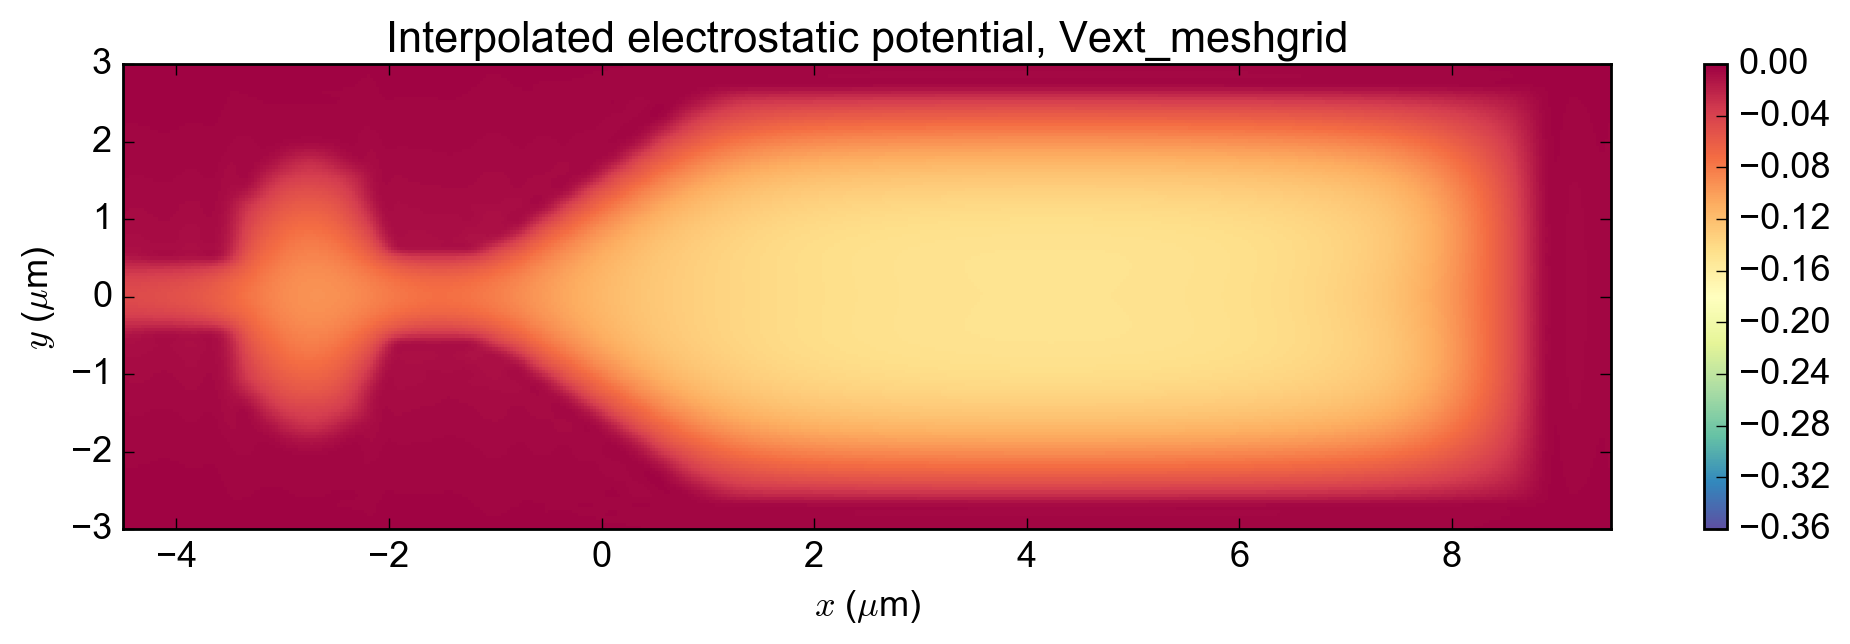

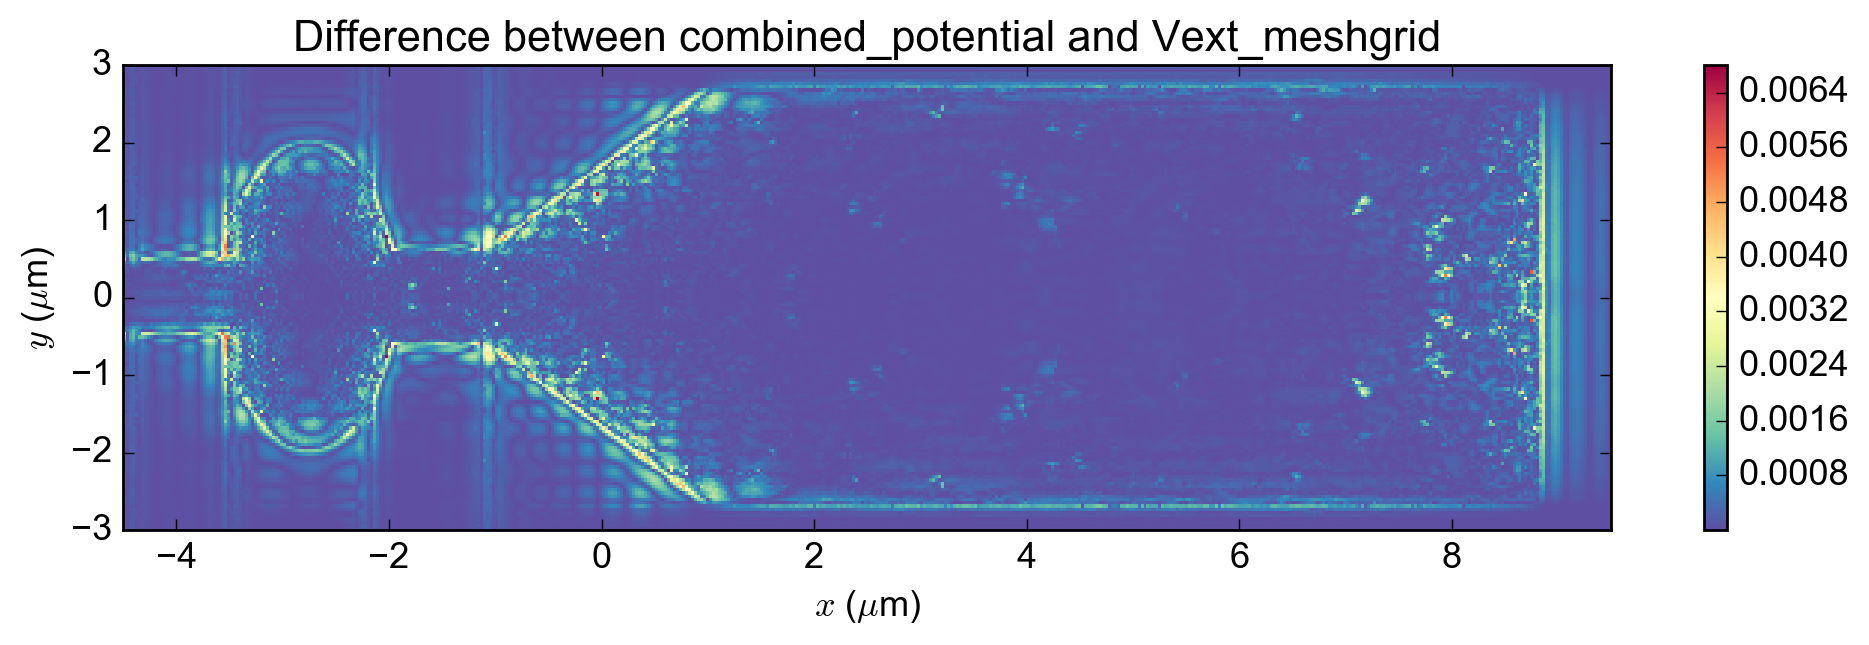

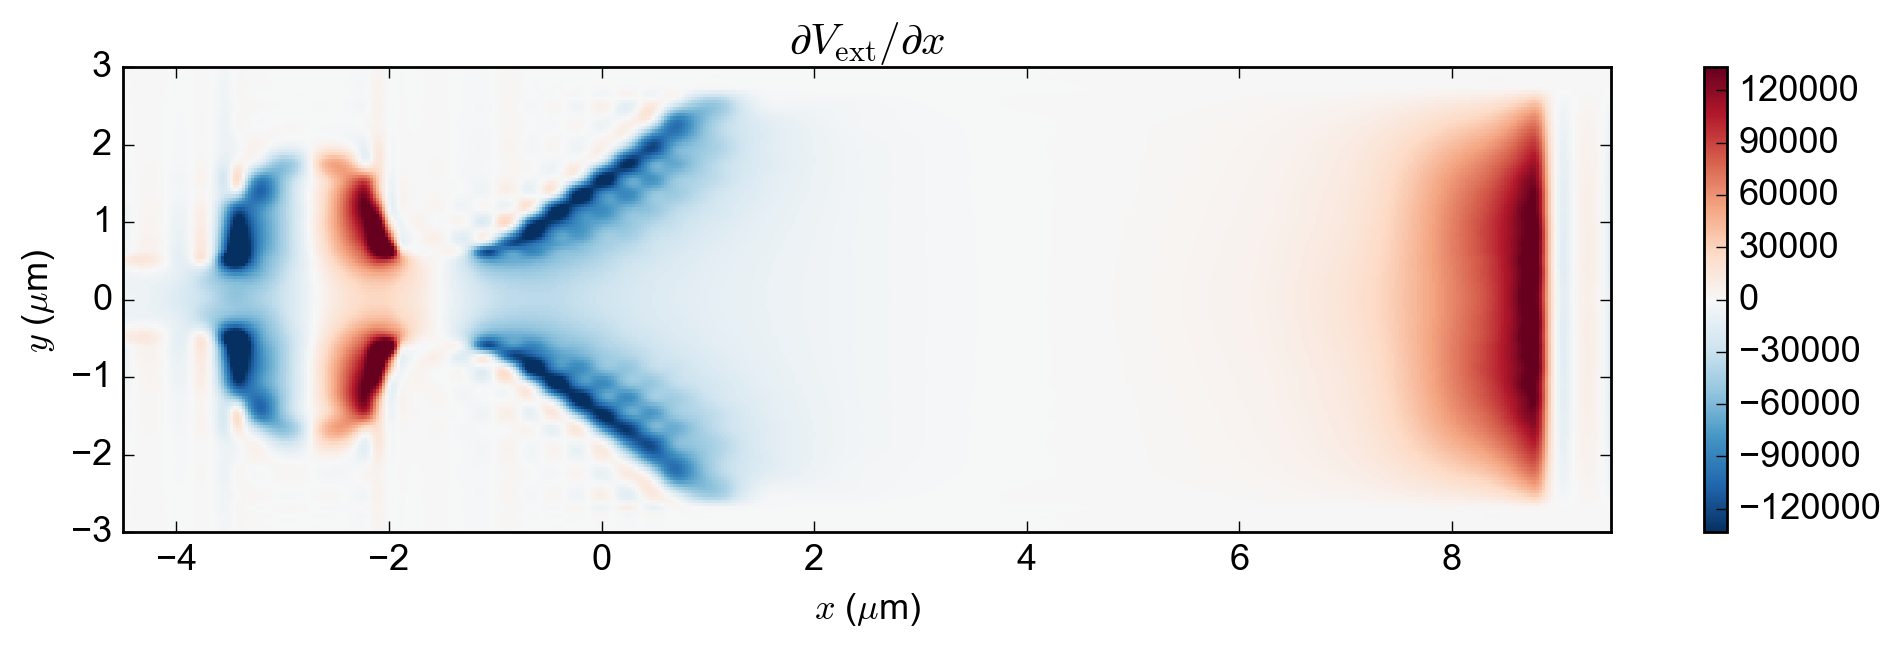

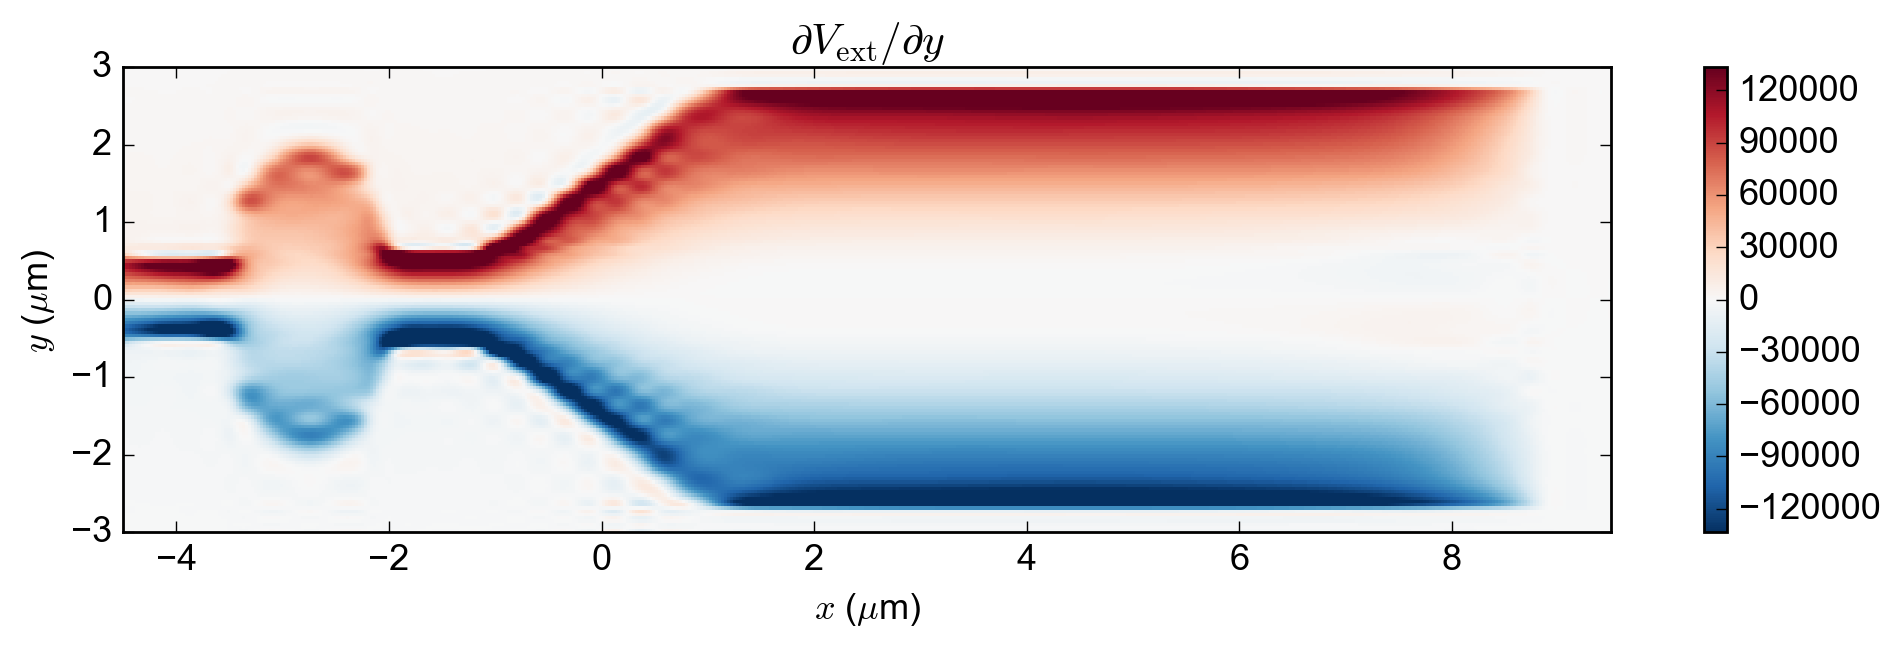

In [19]:
xtest = xeval*1E-6
ytest = yeval*1E-6
Xtest, Ytest = np.meshgrid(xtest, ytest)

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.V(Xtest, Ytest), cmap=plt.cm.Spectral_r, vmin=-0.36, vmax=0.00)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title("Interpolated electrostatic potential, Vext_meshgrid")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

if 1:
    plt.figure(figsize=(12.,3.))
    plt.pcolormesh(Xtest*1E6, Ytest*1E6, np.abs(EP.V(Xtest, Ytest)- (-combined_potential)), 
                   cmap=plt.cm.Spectral_r)
    plt.colorbar()
    plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
    plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
    plt.title(r"Difference between combined_potential and Vext_meshgrid")
    plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdx(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial x$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

plt.figure(figsize=(12.,3.))
plt.pcolormesh(Xtest*1E6, Ytest*1E6, EP.dVdy(Xtest, Ytest), 
               cmap=plt.cm.RdBu_r, vmin=-1E5*Vres/0.15, vmax=1E5*Vres/0.15)
plt.colorbar()
plt.xlim(np.min(xtest)*1E6, np.max(xtest)*1E6)
plt.ylim(np.min(ytest)*1E6, np.max(ytest)*1E6)
plt.title(r"$\partial V_\mathrm{ext}/\partial y$")
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")


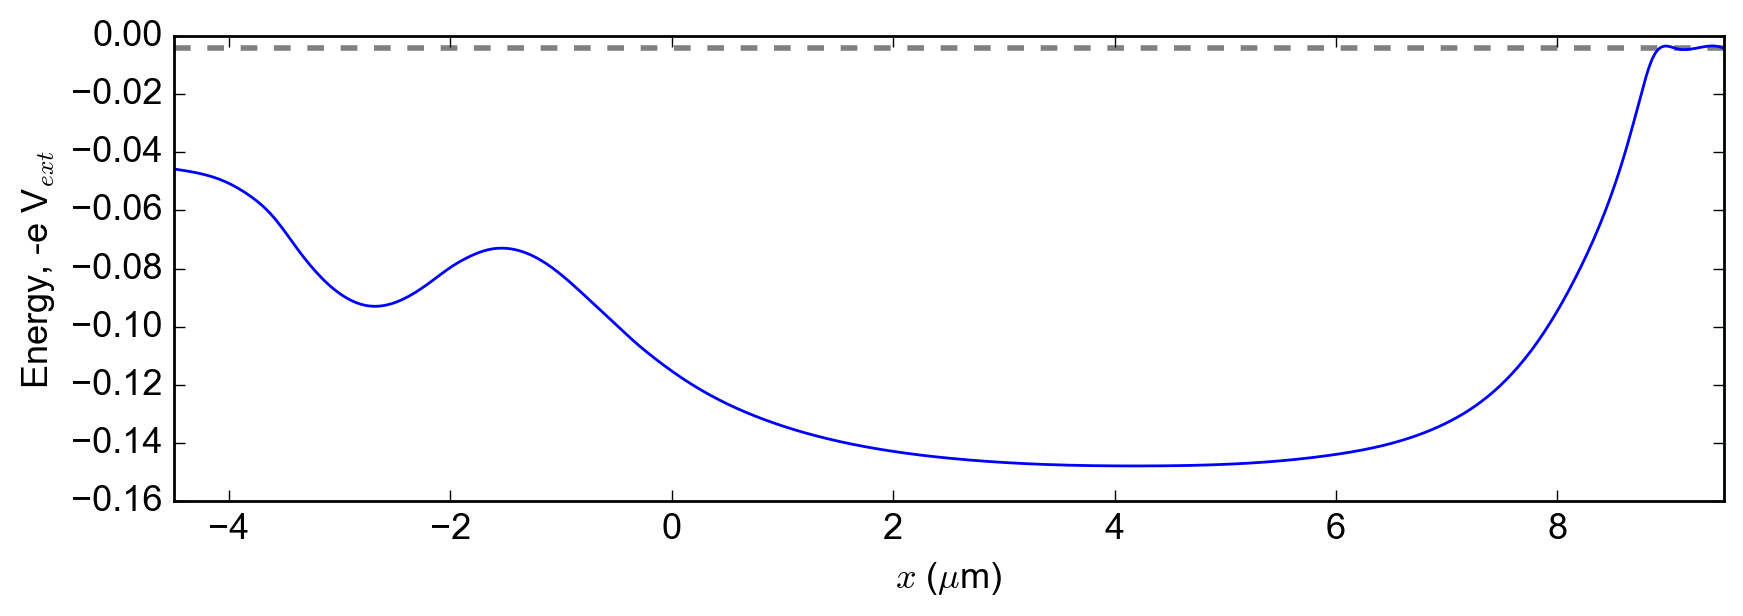

In [20]:
plt.figure(figsize=(10.,3.))
plt.plot(xeval, EP.V(xeval*1E-6, 0E-6))
plt.xlim(np.min(xeval), np.max(xeval))
plt.hlines(EP.V(xeval*1E-6, 0E-6)[-1], np.min(xeval), np.max(xeval), linestyles='--', color='gray', lw=2.0)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("Energy, -e V$_{ext}$")

# Voltage sweep

In [21]:
Vres = 0.10
Vtrap_sweep = np.array(np.linspace(0.40, 0.90, 51).tolist() + np.linspace(0.90, 0.20, 71).tolist())
Vrg = 0.00
Vcg = 0.00
Vtg = -0.20

epsilon = 1e-12
use_gradient = True
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Variable density"
simulation_name = "Vtrap_sweep"

Start with a rectangular grid. Then for each subsequent voltage point, use the previous solution as initial condition.

In [24]:
N_electrons = 15

# Rectangle
N_cols = 5
N_rows = 3
if N_cols*N_rows != N_electrons:
    raise ValueError("N_cols and N_rows are not compatible with N_electrons")
else:
    separation = 200E-9
    x0 = 3.5E-6
    xs = np.linspace(x0, x0+N_cols*separation, N_cols)
    xinit = np.tile(np.array(xs), N_rows)
    ys = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
    yinit = np.repeat(ys, N_cols)

# Add an extra electron
#N_electrons += 1
#xinit = np.append(xinit, x0+(N_cols+1)*separation)
#yinit = np.append(yinit, +(N_rows-1)/2.*separation)

electron_initial_positions = anneal.xy2r(xinit, yinit)

In [25]:
def thermal_kick_x(x, y, T):
    kB = 1.38E-23
    qe = 1.602E-19
    ktrapx = np.abs(qe*EP.ddVdx(xi=x, yi=y))
    return np.sqrt(2*kB*T/ktrapx)

def thermal_kick_y(x, y, T):
    kB = 1.38E-23
    qe = 1.602E-19
    ktrapy = np.abs(qe*EP.ddVdy(xi=x, yi=y))
    return np.sqrt(2*kB*T/ktrapy)

0it [00:00, ?it/s]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


1it [00:02,  2.10s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


2it [00:04,  2.14s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


3it [00:06,  2.12s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


4it [00:08,  2.10s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


5it [00:10,  2.08s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


6it [00:12,  2.19s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


7it [00:15,  2.25s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


8it [00:17,  2.19s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


9it [00:19,  2.13s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


10it [00:21,  2.10s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


11it [00:23,  2.07s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


12it [00:25,  2.07s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


13it [00:27,  2.08s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


14it [00:29,  2.10s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


15it [00:31,  2.09s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


16it [00:33,  2.09s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


17it [00:36,  2.16s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K


18it [00:38,  2.19s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


19it [00:41,  2.31s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


20it [00:43,  2.32s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


21it [00:45,  2.37s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


22it [00:48,  2.33s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


23it [00:50,  2.27s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


24it [00:52,  2.25s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


25it [00:54,  2.18s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


26it [00:56,  2.17s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


27it [00:58,  2.16s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


28it [01:00,  2.17s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


29it [01:03,  2.18s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


30it [01:05,  2.18s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


31it [01:07,  2.18s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


32it [01:09,  2.23s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


33it [01:11,  2.18s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


34it [01:13,  2.14s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


35it [01:16,  2.31s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


36it [01:18,  2.28s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


37it [01:21,  2.24s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


38it [01:23,  2.30s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


39it [01:25,  2.34s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


40it [01:28,  2.39s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


41it [01:30,  2.39s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


42it [01:33,  2.40s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


43it [01:35,  2.40s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


44it [01:38,  2.45s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


45it [01:40,  2.42s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


46it [01:42,  2.40s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


47it [01:45,  2.41s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


48it [01:48,  2.55s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


49it [01:50,  2.54s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state


50it [01:53,  2.49s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


51it [01:55,  2.54s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


52it [01:58,  2.63s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


53it [02:01,  2.68s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


54it [02:03,  2.65s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


55it [02:06,  2.67s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


56it [02:09,  2.57s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


57it [02:11,  2.65s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


58it [02:14,  2.64s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


59it [02:16,  2.59s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


60it [02:19,  2.54s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


61it [02:21,  2.51s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


62it [02:24,  2.48s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


63it [02:26,  2.47s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


64it [02:29,  2.42s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


65it [02:31,  2.41s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


66it [02:33,  2.39s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


67it [02:36,  2.42s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


68it [02:38,  2.41s/it]

Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
There is a lower energy state, but the minimizer did not converge
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


69it [02:40,  2.36s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


70it [02:43,  2.32s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


71it [02:45,  2.34s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


72it [02:47,  2.34s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Found new minimum


73it [02:50,  2.34s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


74it [02:52,  2.33s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


75it [02:55,  2.42s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


76it [02:57,  2.39s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


77it [02:59,  2.45s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


78it [03:02,  2.45s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


79it [03:04,  2.45s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


80it [03:07,  2.39s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


81it [03:09,  2.36s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


82it [03:11,  2.33s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


83it [03:13,  2.32s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


84it [03:16,  2.31s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


85it [03:18,  2.31s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


86it [03:20,  2.29s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


87it [03:23,  2.27s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


88it [03:25,  2.26s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


89it [03:27,  2.24s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


90it [03:29,  2.26s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


91it [03:32,  2.26s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


92it [03:34,  2.22s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


93it [03:36,  2.22s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


94it [03:38,  2.31s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


95it [03:41,  2.26s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


96it [03:43,  2.22s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


97it [03:45,  2.21s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


98it [03:47,  2.19s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


99it [03:49,  2.18s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


100it [03:52,  2.23s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


101it [03:54,  2.23s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


102it [03:56,  2.21s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


103it [03:58,  2.19s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


104it [04:00,  2.17s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum


105it [04:02,  2.19s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


106it [04:05,  2.18s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


107it [04:07,  2.17s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


108it [04:09,  2.17s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


109it [04:11,  2.17s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


110it [04:13,  2.16s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


111it [04:15,  2.15s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K


112it [04:17,  2.15s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


113it [04:20,  2.24s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


114it [04:22,  2.24s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


115it [04:24,  2.20s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Minimizer did not converge, but this is not a lower energy state
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


116it [04:27,  2.21s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


117it [04:29,  2.34s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


118it [04:31,  2.34s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


119it [04:34,  2.31s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


120it [04:36,  2.27s/it]

Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


121it [04:38,  2.21s/it]

Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Found new minimum
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K
Perturbing final state at T = 5.00e-01 K


122it [04:40,  2.17s/it]


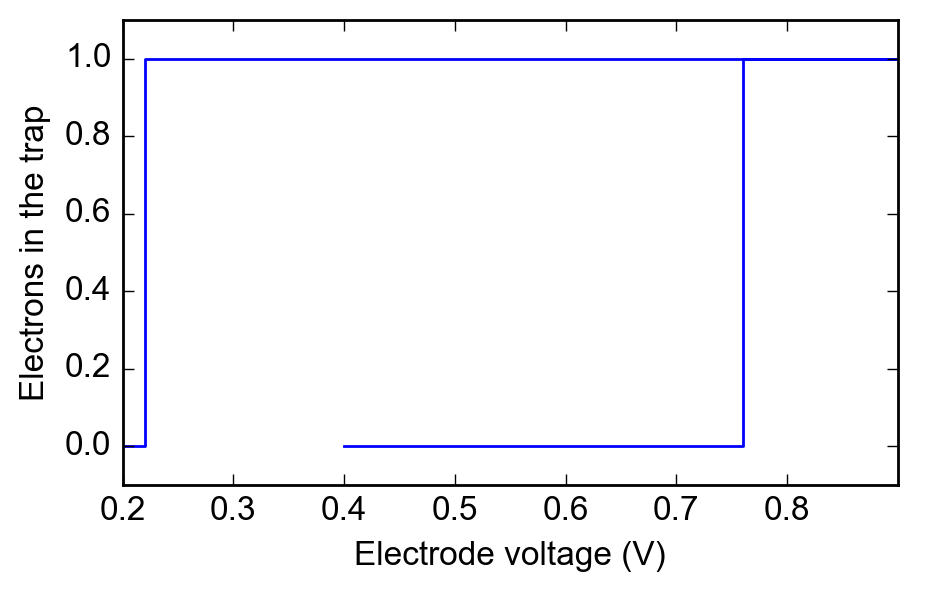

In [29]:
electrons_in_trap = list()
successful_V = list()
annealing_steps = [0.5]*10
num_trapped_electrons = list()
Xeval, Yeval = np.meshgrid(xeval*1E-6, yeval*1E-6)
reload(anneal)

sub_dir = time.strftime("%y%m%d_%H%M%S_{}".format(simulation_name))
os.mkdir(os.path.join(save_path, sub_dir))
time.sleep(1)
os.mkdir(os.path.join(save_path, sub_dir, "Figures"))
# Save the data to a single file
f = h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "w")

for k, Vtrap in tqdm(enumerate(Vtrap_sweep)):
    
    xeval, yeval, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)
    coefficients = np.array([Vres, Vtrap, Vrg, Vcg, Vtg])
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

    EP = anneal.ElectrostaticPotential(xeval*1E-6, yeval*1E-6, -combined_potential.T, 
                                       spline_order_x=3, spline_order_y=3, smoothing=0.01)

    ConvMon = anneal.ConvergenceMonitor(Uopt=EP.Vtotal, grad_Uopt=EP.grad_total, N=500, Uext=EP.V, 
                                        xext=xeval*1E-6, yext=yeval*1E-6, verbose=False, eps=epsilon, 
                                        save_path=os.path.join(save_path, sub_dir, "Figures"))

    PP = anneal.PostProcess(save_path=os.path.join(save_path, sub_dir, "Figures"))
    
    if use_gradient: 
        jac=EP.grad_total
    else:
        jac = None
    
    # First minimization...
    res = minimize(EP.Vtotal, electron_initial_positions, method='CG', 
                   jac=jac, 
                   options={'disp': False, 'gtol' : 1E-1}, 
                   callback=ConvMon.monitor_convergence)
    
    
    # Perturb the system to see if we got the global minimum.
    perturbed_positions = np.zeros(len(electron_initial_positions))
    x_a, y_a = anneal.r2xy(res['x']) 
    final_func_val = res['fun']

    # Restart convergence monitor
    ConvMon.call_counter = 0
    ConvMon.figsize = (8.,2.)
    
    valid_solution = res
    
    for A, T in enumerate(annealing_steps):    
        cprint("Perturbing final state at T = %.2e K"%(T), 'blue')

        perturbed_x = x_a + thermal_kick_x(x_a, y_a, T) * np.random.rand(len(x_a))
        perturbed_y = y_a + thermal_kick_y(x_a, y_a, T) * np.random.rand(len(y_a))

        perturbed_positions[::2] = perturbed_x
        perturbed_positions[1::2] = perturbed_y

        res = minimize(EP.Vtotal, perturbed_positions, method='CG', 
                       jac=jac, 
                       options={'disp': False, 'gtol' : 1E-1}, 
                       callback=ConvMon.monitor_convergence)

        num_trapped_electrons.append(PP.get_trapped_electrons(res['x']))

        if res['fun'] < final_func_val and res['status'] == 0:
            cprint("Found new minimum", "green")
            final_func_val = res['fun']
            x_pre_anneal, y_pre_anneal = anneal.r2xy(res['x'])
            jac_pre_anneal = np.amax(np.abs(res['jac']))
            valid_solution = res

        elif res['fun'] < final_func_val and res['status'] > 0:
            cprint("There is a lower energy state, but the minimizer did not converge", "red")

        elif res['fun'] >= final_func_val and res['status'] > 0:
            cprint("Minimizer did not converge, but this is not a lower energy state", "magenta")
    
    if valid_solution["status"] == 0:
        #cprint("Optimization successful.", 'green')
        
        x, y = anneal.r2xy(valid_solution['x'])
        final_func_val = valid_solution['fun']
        n_iterations = valid_solution['nit']

        PP.save_snapshot(valid_solution['x'], xext=xeval*1E-6, yext=yeval*1E-6, 
                         Uext=EP.V, clim=(-0.20, 0), 
                         common=common, figsize=(8.,2.), title="V = %.5f V"%Vtrap)

        successful_V.append(Vtrap)
        electrons_in_trap.append(PP.get_trapped_electrons(valid_solution['x']))
        
        # Use solution as initial condition for next voltage point
        electron_initial_positions = valid_solution['x']
    else:
        cprint("Optimization failed! Not saving step #%d"%k, 'red')  
        
    f.create_dataset("step_%04d/potential_x"%k, data=xeval*1E-6)
    f.create_dataset("step_%04d/potential_y"%k, data=yeval*1E-6)
    f.create_dataset("step_%04d/potential_V"%k, data=EP.V(Xeval*1E-6, Yeval*1E-6))
    f.create_dataset("step_%04d/potential_coefficients"%k, data=coefficients)
    f.create_dataset("step_%04d/use_gradient"%k, data=use_gradient)
    f.create_dataset("step_%04d/electron_final_coordinates"%k, data=valid_solution['x'])
    f.create_dataset("step_%04d/electron_initial_coordinates"%k, data=electron_initial_positions)
    f.create_dataset("step_%04d/solution_valid"%k, data=valid_solution['status'])
    f.create_dataset("step_%04d/energy"%k, data=valid_solution['fun'])
    f.create_dataset("step_%04d/jacobian"%k, data=valid_solution['jac'])
    f.create_dataset("step_%04d/electrons_in_trap"%k, data=PP.get_trapped_electrons(valid_solution['x']))

f.close()
    
# Show electrons in trap as function of the sweep coordinate
fig = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.step(successful_V, electrons_in_trap)
plt.ylim((-0.1, np.max(electrons_in_trap)+0.1))
plt.xlim(np.min(Vtrap_sweep), np.max(Vtrap_sweep))
plt.ylabel("Electrons in the trap")
plt.xlabel("Electrode voltage (V)")
fig.savefig(os.path.join(save_path, sub_dir, "Electrons_in_trap.png"), dpi=300, bbox_inches='tight')

# Create a movie
ConvMon.create_movie(fps=10, 
                     filenames_in=time.strftime("%Y%m%d")+"_figure_%05d.png", 
                     filename_out="%d_electrons_electrode_sweep.mp4"%(N_electrons))

# Move the file from the Figures folder to the sub folder
os.rename(os.path.join(save_path, sub_dir, "Figures/%d_electrons_electrode_sweep.mp4"%(N_electrons)), \
          os.path.join(save_path, sub_dir, "%d_electrons_electrode_sweep.mp4"%(N_electrons)))

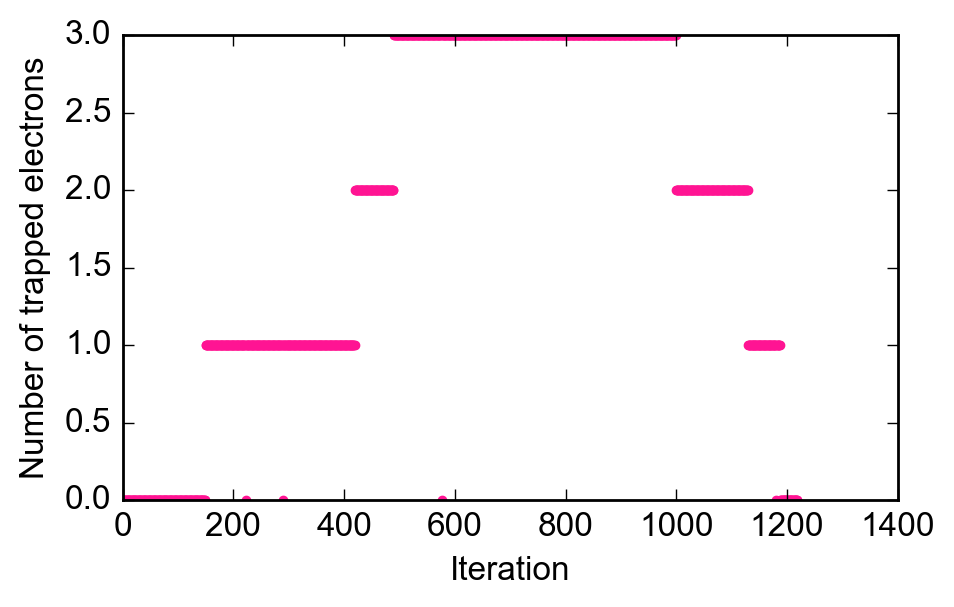

In [20]:
# Plot number of trapped electrons
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(num_trapped_electrons, '.', color='deeppink')
plt.xlabel("Iteration")
plt.ylabel("Number of trapped electrons")

In [ ]:
ConvMon.create_movie(fps=10, 
                     filenames_in=time.strftime("%Y%m%d")+"_figure_%05d.png", 
                     filename_out="%d_electrons_electrode_sweep.mp4"%(N_electrons))

In [ ]:
plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.step(Vtrap_sweep[:len(electrons_in_trap)], electrons_in_trap)
plt.ylim((-0.1, np.max(electrons_in_trap)+0.1))
plt.xlim(np.min(Vtrap_sweep), np.max(Vtrap_sweep))
plt.ylabel("Electrons in the trap")
plt.xlabel("Electrode voltage (V)")

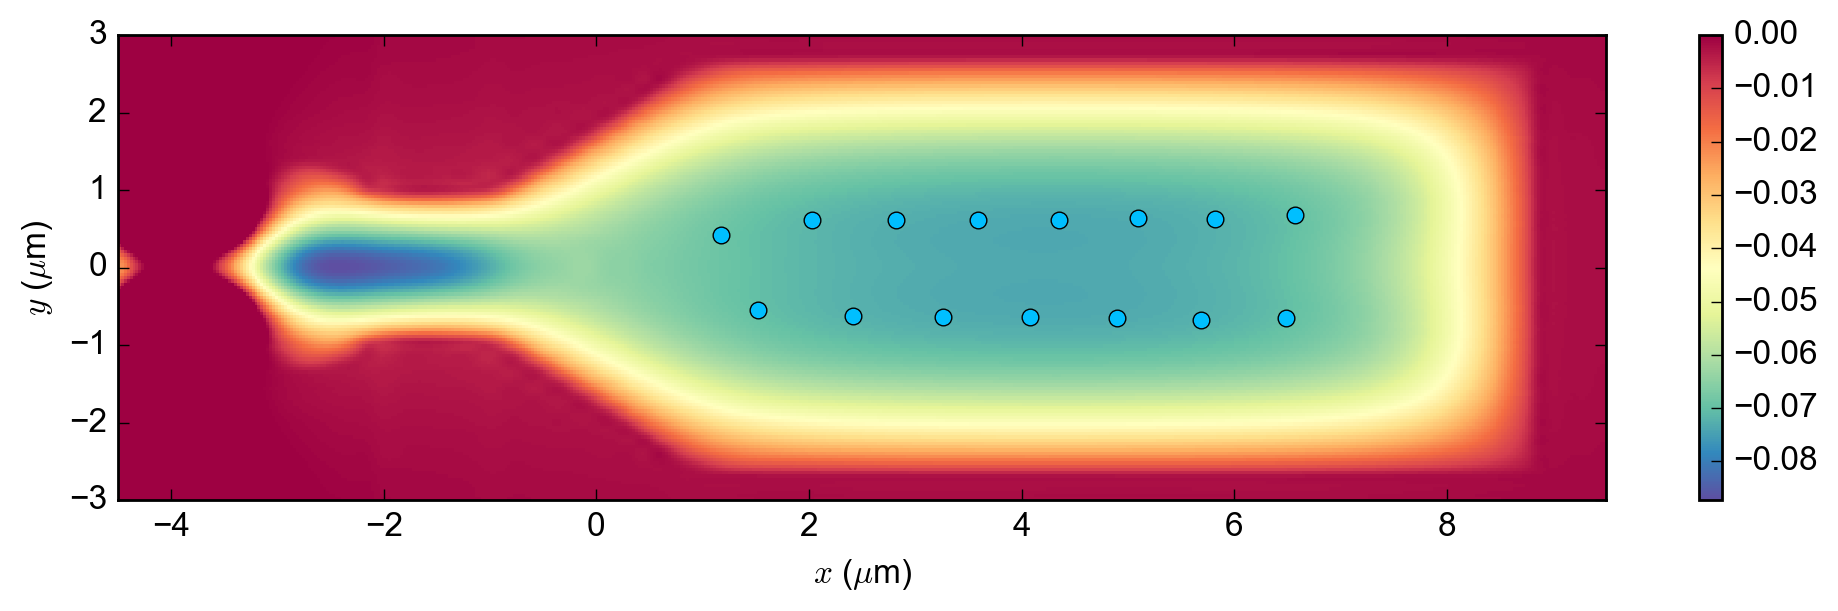

In [17]:
%matplotlib inline

Xinit, Yinit = anneal.map_into_domain(xinit, yinit)
X, Y = anneal.map_into_domain(res['x'][::2], res['x'][1::2])
Xeval, Yeval = np.meshgrid(xeval, yeval)

figgy = plt.figure(figsize=(12,3))
common.configure_axes(12)
plt.pcolormesh(xeval, yeval, EP.V(Xeval*1E-6, Yeval*1E-6), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(X*1E6, Y*1E6, 'o', color='deepskyblue')

plt.xlim(np.min(xeval), np.max(xeval))
plt.ylim(np.min(yeval), np.max(yeval))
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save: 
    common.save_figure(figgy, save_path=save_path)

In [3]:
x = np.arange(10)

In [9]:
x[-5:]

array([5, 6, 7, 8, 9])

In [6]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])